In [104]:
import pandas as pd
import numpy as np
import warnings
import os
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

"""
sns 相关设置
@return:
"""
# 声明使用 Seaborn 样式
sns.set()
# 有五种seaborn的绘图风格，它们分别是：darkgrid, whitegrid, dark, white, ticks。默认的主题是darkgrid。
sns.set_style("whitegrid")
# 有四个预置的环境，按大小从小到大排列分别为：paper, notebook, talk, poster。其中，notebook是默认的。
sns.set_context('talk')
# 中文字体设置-黑体
plt.rcParams['font.sans-serif'] = ['SimHei']
# 解决保存图像是负号'-'显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False
# 解决Seaborn中文显示问题并调整字体大小
sns.set(font='SimHei')

reference: https://github.com/datawhalechina/team-learning-data-mining/blob/master/FinancialRiskControl/Task4%20%E5%BB%BA%E6%A8%A1%E8%B0%83%E5%8F%82.md

# 读取数据

In [2]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [39]:
data = pd.read_csv('5001process_train.csv')
data = reduce_mem_usage(data)

X_train = data.drop('isDefault', axis=1)
y_train = data['isDefault']
# 数据集划分
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2)
train_matrix = lgb.Dataset(X_train_split, label=y_train_split)
valid_matrix = lgb.Dataset(X_val, label=y_val)

Memory usage of dataframe is 345248064.00 MB
Memory usage after optimization is: 84683584.00 MB
Decreased by 75.5%


# 建模 lightgbm

In [40]:
# 5折交叉验证
folds = 5
seed = 2020
kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

In [41]:
"""对训练集数据进行划分，分成训练集和验证集，并进行相应的操作"""
from sklearn.model_selection import train_test_split
import lightgbm as lgb

params = {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'learning_rate': 0.1,
            'metric': 'auc',
            'min_child_weight': 1e-3,
            'num_leaves': 31,
            'max_depth': -1,
            'reg_lambda': 0,
            'reg_alpha': 0,
            'feature_fraction': 1,
            'bagging_fraction': 1,
            'bagging_freq': 0,
            'seed': 2020,
            'nthread': 8,
            'silent': True,
            'verbose': -1,
}

"""使用训练集数据进行模型训练"""
model = lgb.train(params, train_set=train_matrix, valid_sets=valid_matrix, num_boost_round=20000, verbose_eval=1000, early_stopping_rounds=200)

C:\Users\huanglamu\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\huanglamu\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\huanglamu\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `param

[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[216]	valid_0's auc: 0.736073


AUC on validation set：0.7360727222623897


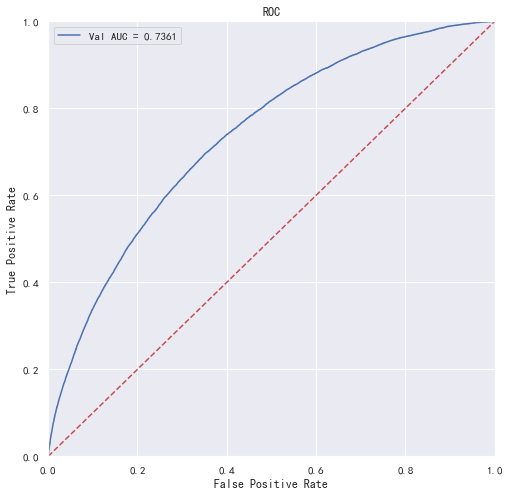

In [42]:
"""预测并计算roc的相关指标"""
val_pre_lgb = model.predict(X_val, num_iteration=model.best_iteration)
fpr, tpr, threshold = metrics.roc_curve(y_val, val_pre_lgb)
roc_auc = metrics.auc(fpr, tpr)
print('AUC on validation set：{}'.format(roc_auc))
"""画出roc曲线图"""
plt.figure(figsize=(8, 8))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.4f' % roc_auc)
plt.ylim(0,1)
plt.xlim(0,1)
plt.legend(loc='best')
plt.title('ROC')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# 画出对角线
plt.plot([0,1],[0,1],'r--')
plt.show()

## 特征重要性

<Figure size 432x288 with 0 Axes>

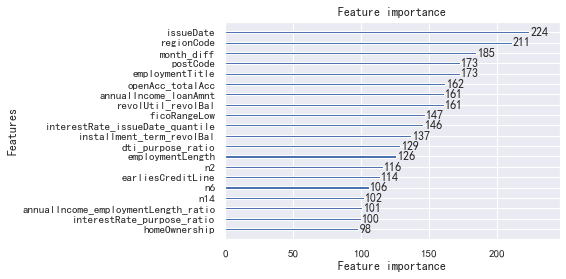

In [61]:
plt.figure()
a = lgb.plot_importance(model, max_num_features=20)
plt.show()

# Logistic Regression

## 数据处理

In [44]:
train_lr = X_train.drop(["regionCode", "issueDate", "earliesCreditLine", "postCode", "title", "employmentTitle"], axis=1)
train_lr =  pd.get_dummies(train_lr, columns=['grade', 'subGrade', 'delinquency_2years','homeOwnership','initialListStatus', 'applicationType' ,'employmentLength', 'verificationStatus', 'purpose', 'annualIncome_bin', 'loanAmnt_bin', 'interestRate_bin', 'dti_bin', 'installment_bin', 'revolBal_bin', 'revolUtil_bin'], drop_first=True)

In [45]:
from sklearn.linear_model import LogisticRegression as lr

LR = lr(random_state=0, max_iter=1000, class_weight='balanced')
LR.fit(X_train_split, y_train_split)
y_predict = LR.predict(X_val)

fpr, tpr, threshold = metrics.roc_curve(y_val, y_predict)
roc_auc = metrics.auc(fpr, tpr)
print(f'auc score:{roc_auc}')

auc score:0.6207673311229425


C:\Users\huanglamu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [120]:
importance = pd.DataFrame(pow(math.e, np.std(X_train_split, 0) * LR.coef_[0])).sort_values(by=0, ascending=True).iloc[-20:, :]

<BarContainer object of 20 artists>

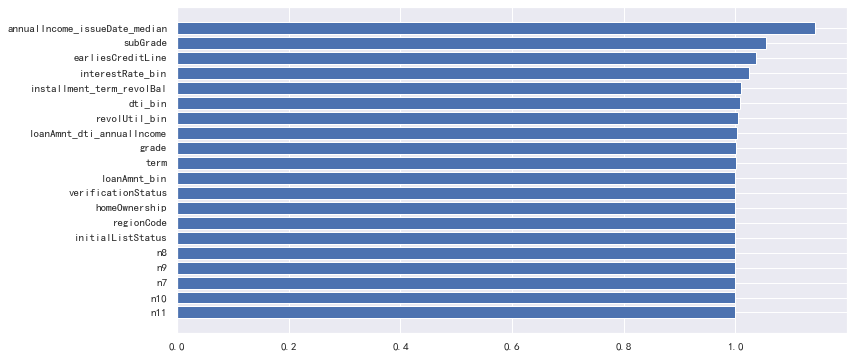

In [121]:
plt.figure(figsize=(12,6))
plt.barh(pd.DataFrame(importance.index)[0], importance[0])